In [1]:
import os
os.chdir("d:/python_projects/london-city-bikes")

import numpy as np
import torch
import matplotlib.pyplot as plt
import mlflow 

In [2]:
from src.dataset import get_dataloaders
from src.model import LSTMModel, LinearWeightedMSELoss
from src.const import (
    DEVICE,
    PRED_LENGTH,
    INPUT_SIZE,
    FUTURE_FEATURE_SIZE,
    HIDDEN_SIZE,
    OUTPUT_SIZE,
    NUM_LAYERS,
    NUM_EPOCHS,
    DROPOUT,
    LEARNING_RATE,
    USE_CLUSTER_EMBEDDING
)
from src.paths import MODELS_DIR
from src.train import train_model
from src.metrics import evaluate_predictions
from src.predict import predict
from src.mlflow_logging import log_trained_model, log_true_and_predictions_values
from src.mlflow_logging import log_model_architecture
from src.mlflow_logging import log_train_parameters_with_embedding

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [3]:
MODELS_BASENAME = "pytorch_model"
MODEL_PATH = os.path.join(MODELS_DIR, f'{MODELS_BASENAME}_with_embeddings.pth')
CHECKPOINT_PATH = os.path.join(MODELS_DIR, f'{MODELS_BASENAME}_checkpoint_with_embeddings.pth')

print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
train_dataloader, val_dataloader, cluster_id_map = get_dataloaders(years=[2021])


In [5]:
len(train_dataloader)

1598

In [6]:
len(val_dataloader)

366

# Training

In [7]:
# Hyperparameters
INPUT_SIZE = 12
FUTURE_FEATURE_SIZE = 10
HIDDEN_SIZE = 128
OUTPUT_SIZE = 2 * PRED_LENGTH
NUM_LAYERS = 1
NUM_EPOCHS = 5
DROPOUT = 0
LEARNING_RATE = 0.0001
USE_CLUSTER_EMBEDDING = True

In [8]:
# Hyperparameters
INPUT_SIZE = 12
FUTURE_FEATURE_SIZE = 10
HIDDEN_SIZE = 512
OUTPUT_SIZE = 2 * PRED_LENGTH
NUM_LAYERS = 2
NUM_EPOCHS = 20
DROPOUT = 0
LEARNING_RATE = 0.0001
USE_CLUSTER_EMBEDDING = True

# Train one model for all clusters

train
Epoch [1/5] - Train Loss: 0.0097, Train MAE: 0.0614, Val Loss: 0.0052, Val MAE: 0.0489
Epoch [2/5] - Train Loss: 0.0058, Train MAE: 0.0478, Val Loss: 0.0049, Val MAE: 0.0474
Epoch [3/5] - Train Loss: 0.0052, Train MAE: 0.0451, Val Loss: 0.0053, Val MAE: 0.0499
Epoch [4/5] - Train Loss: 0.0047, Train MAE: 0.0432, Val Loss: 0.0048, Val MAE: 0.0468
Epoch [5/5] - Train Loss: 0.0043, Train MAE: 0.0417, Val Loss: 0.0050, Val MAE: 0.0483
Best model from epoch 4 with val loss: 0.0048


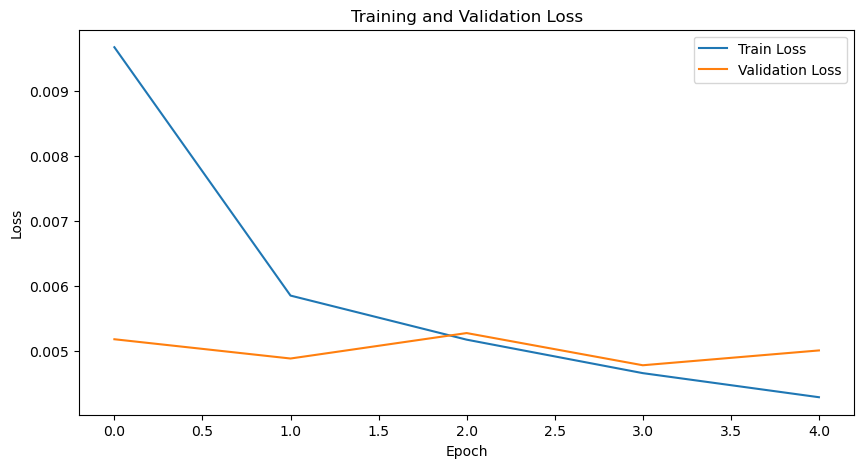

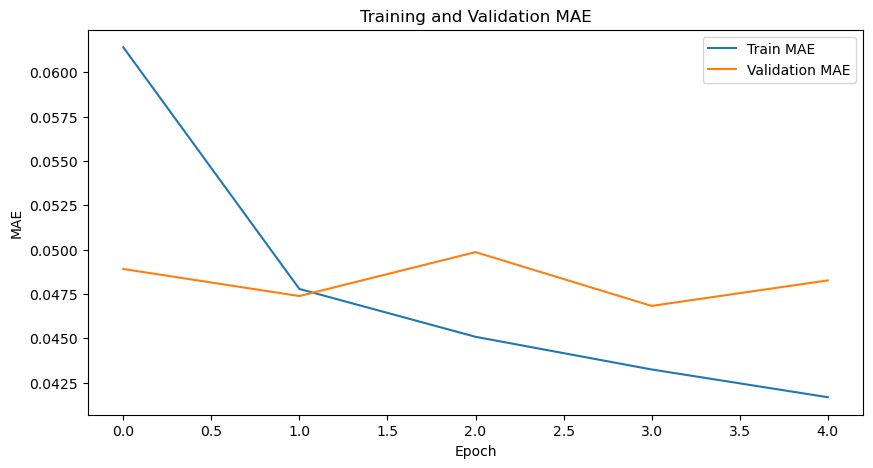

2025/09/14 19:02:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/14 19:02:25 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/14 19:02:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


predict
evaluate
Metrics:
  MAE: 7.2581, RMSE: 10.9221, R2: 0.7133, sMAPE: 63.9925%


In [7]:
model = LSTMModel(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    future_feature_size=FUTURE_FEATURE_SIZE,
    output_size=OUTPUT_SIZE,
    pred_length=PRED_LENGTH,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    use_cluster_embedding=USE_CLUSTER_EMBEDDING,
    num_clusters=len(cluster_id_map),
    
    cluster_emb_size=8
).to(DEVICE)

criterion = LinearWeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

mlflow.start_run()
log_model_architecture(model)
log_train_parameters_with_embedding(NUM_EPOCHS, optimizer, criterion, train_dataloader.batch_size, USE_CLUSTER_EMBEDDING)
print("train")
model, checkpoint = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs=NUM_EPOCHS)
torch.save(model, MODEL_PATH)
torch.save(checkpoint, CHECKPOINT_PATH)
log_trained_model(model, MODELS_BASENAME + "_with_embedding.pth")

all_preds = {}
all_true = {}
print("predict")
preds, true_vals, metadata = predict(model, val_dataloader)
print("evaluate")
metrics = evaluate_predictions(true_vals, preds, metadata)
print(f"Metrics:")
print(f"  MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}, R2: {metrics['R2']:.4f}, sMAPE: {metrics['sMAPE']:.4f}%")

np.save(f"./data/results/true_values.npy", true_vals)
np.save(f"./data/results/predictions.npy", preds)
log_true_and_predictions_values(f"./data/results/true_values.npy", f"./data/results/predictions.npy")

mlflow.end_run()

In [10]:
48*365*30*0.2

105120.0

In [15]:
len(true_vals)

102840

In [8]:
index = PRED_LENGTH * 1

selected_true = true_vals[index]
selected_predictions = preds[index]

# Extract true and predicted values for Starts and Ends
true_starts = selected_true[:, 0]  # Shape: (pred_length)
true_ends = selected_true[:, 1]    # Shape: (pred_length)
pred_starts = selected_predictions[:, 0]  # Shape: (pred_length)
pred_ends = selected_predictions[:, 1]    # Shape: (pred_length)

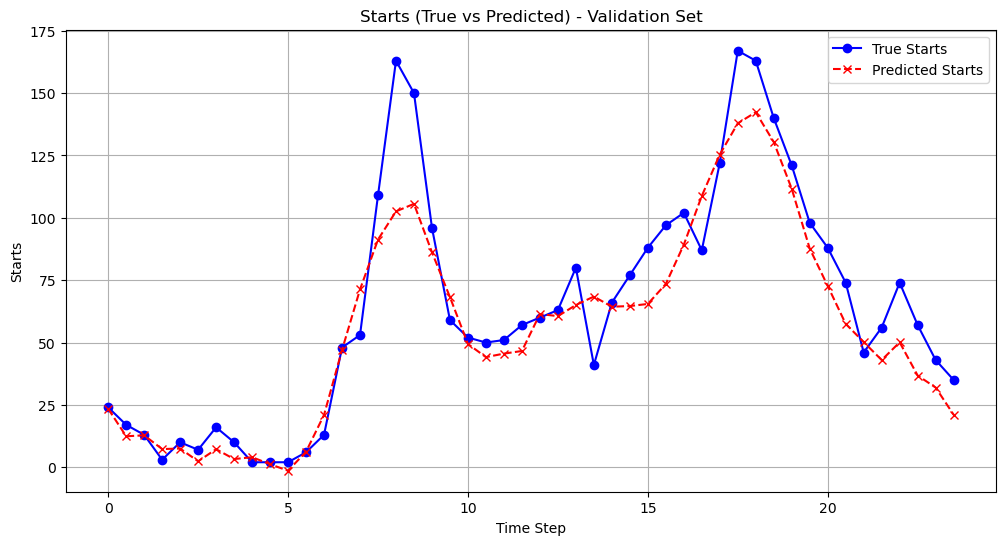

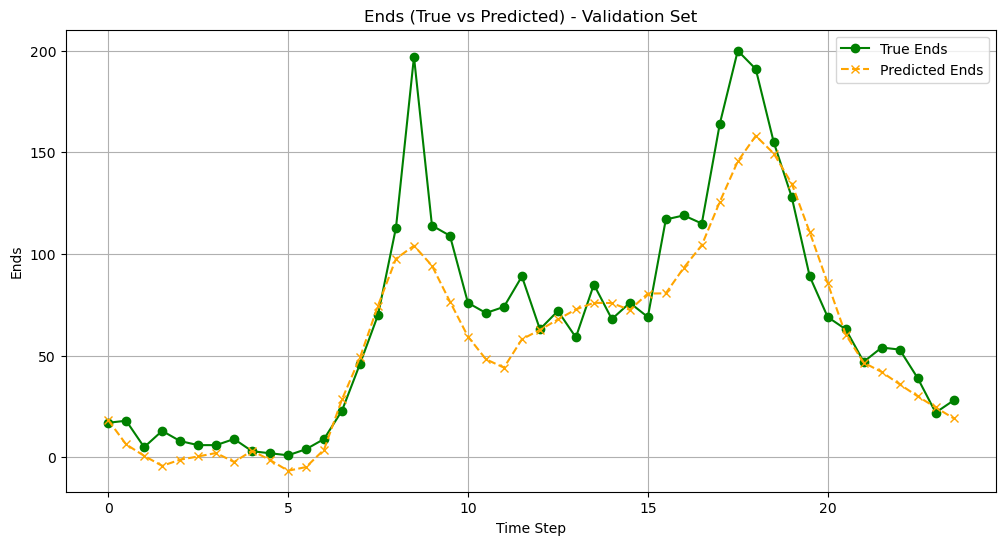

In [9]:
# Plot Starts for the first sample in the batch
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), true_starts, label="True Starts", color="blue", marker="o")
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), pred_starts, label="Predicted Starts", color="red", linestyle="--", marker="x")
plt.title(f"Starts (True vs Predicted) - Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Starts")
plt.legend()
plt.grid(True)
plt.show()

# Plot Ends for the first sample in the batch
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), true_ends, label="True Ends", color="green", marker="o")
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), pred_ends, label="Predicted Ends", color="orange", linestyle="--", marker="x")
plt.title(f"Ends (True vs Predicted) - Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Ends")
plt.legend()
plt.grid(True)
plt.show()